# $\mathbf{Proyección~de~robos~para~los~meses~de~Junio,~Julio~y~Agosto}$

# Dependencias

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from scipy import stats

import cufflinks as cf
import matplotlib.pyplot as plt
import seaborn as sns

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

Dado que los datos de la página asignada están actualizados hasta el mes de junio de 2023, se utilizara sin
considerar este ultimo mes

In [2]:
archivo ='IDM_NM_jun23.csv'
df = pd.read_csv(archivo, encoding='latin-1')
df = df.loc[df['Bien jurídico afectado']=='El patrimonio'].loc[df['Tipo de delito']=='Robo'].reset_index(drop=True)
df.head()

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,2015,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo a casa habitación,Con violencia,4,3,0,7,4,6,4.0,3.0,4.0,1.0,4.0,7.0
1,2015,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo a casa habitación,Sin violencia,172,151,181,155,170,182,173.0,168.0,158.0,144.0,201.0,171.0
2,2015,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,4,1,4,3,0,1,1.0,5.0,2.0,5.0,6.0,4.0
3,2015,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,114,106,122,124,138,94,89.0,93.0,126.0,105.0,152.0,171.0
4,2015,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Con violencia,1,0,1,0,0,0,0.0,2.0,0.0,0.0,1.0,0.0


In [3]:
df.shape

(762516, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762516 entries, 0 to 762515
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Año                     762516 non-null  int64  
 1   Clave_Ent               762516 non-null  int64  
 2   Entidad                 762516 non-null  object 
 3   Cve. Municipio          762516 non-null  int64  
 4   Municipio               762516 non-null  object 
 5   Bien jurídico afectado  762516 non-null  object 
 6   Tipo de delito          762516 non-null  object 
 7   Subtipo de delito       762516 non-null  object 
 8   Modalidad               762516 non-null  object 
 9   Enero                   762516 non-null  int64  
 10  Febrero                 762516 non-null  int64  
 11  Marzo                   762516 non-null  int64  
 12  Abril                   762516 non-null  int64  
 13  Mayo                    762516 non-null  int64  
 14  Junio               

# Definición de variables

In [5]:
df.insert(0,'id',df.index+1)

In [6]:
um = ['id']
vart_1 = ['Junio']
vart_2 = ['Julio']
vart_3 = ['Agosto']
vard = ['Subtipo de delito','Modalidad']
varc_1 = ['Año']+['Clave_Ent']+['Cve. Municipio']+list(df.columns[10:][:5])
varc_2 = ['Año']+['Clave_Ent']+['Cve. Municipio']+list(df.columns[10:][:6])
varc_3 = ['Año']+['Clave_Ent']+['Cve. Municipio']+list(df.columns[10:][:7])

# Análisis exploratorio

## Variables continuas

### Valores nulos

In [7]:
X = df[df.columns[:-4]].copy()

In [8]:
nulos = 1-X[X.columns[1:]].describe().T[['count']]/len(X)
nulos

,count
Año,0.000000
Clave_Ent,0.000000
Cve. Municipio,0.000000
Enero,0.000000
Febrero,0.000000
Marzo,0.000000
Abril,0.000000
Mayo,0.000000
Junio,0.000000
Julio,0.117228


### Varianza nula

In [9]:
vt = VarianceThreshold()
vt.fit(X.loc[X['Año']<2023][varc_3])

VarianceThreshold()

In [10]:
fuera = [a for a,b in zip(varc_3,vt.get_support()) if not b]
fuera

[]

## Variables discretas

### Valores nulos

In [11]:
nulos = X[vard].isnull().sum()/len(X)
nulos

Subtipo de delito    0.0
Modalidad            0.0
dtype: float64

### Conversión a variables numéricas

In [12]:
for v in vard:
    for a,b in zip(list(X[v].unique()),range(1,len(list(X[v].unique()))+1)):
        X.loc[X[v] == a, v] = b
    X[v] = pd.to_numeric(X[v])

### Varianza nula

In [13]:
vt.fit(X.loc[X['Año']<2023][vard])

VarianceThreshold()

In [14]:
fuera = [a for a,b in zip(vard,vt.get_support()) if not b]
fuera

[]

In [15]:
var_1 = varc_1 + vard
var_2 = varc_2 + vard
var_3 = varc_3 + vard

## Partición general

In [16]:
Xi = X.loc[X['Año']<2023]

In [17]:
Xi.shape

(673128, 18)

## Selección de variables con mejor poder predictivo

### Para vart_1 (Junio)

In [18]:
sk = SelectKBest(k=len(var_1),score_func = f_regression)
sk.fit(Xi[var_1],Xi[vart_1[0]])

SelectKBest(score_func=<function f_regression at 0x7f61c124ed40>)

In [19]:
pd.DataFrame(zip(var_1,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                  ascending=False).iplot(kind='bar',color='orange')

In [20]:
sk = SelectKBest(k=5,score_func = f_regression)
sk.fit(Xi[var_1],Xi[vart_1[0]])

SelectKBest(k=5, score_func=<function f_regression at 0x7f61c124ed40>)

In [21]:
best_1 = [a for a,b in zip(var_1,sk.get_support()) if b]
best_1

['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo']

### Para vart_2 (Julio)

In [22]:
sk = SelectKBest(k=len(var_2),score_func = f_regression)
sk.fit(Xi[var_2],Xi[vart_2[0]])

SelectKBest(k=11, score_func=<function f_regression at 0x7f61c124ed40>)

In [23]:
pd.DataFrame(zip(var_2,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                  ascending=False).iplot(kind='bar',color='orange')

In [24]:
sk = SelectKBest(k=6,score_func = f_regression)
sk.fit(Xi[var_2],Xi[vart_2[0]])

SelectKBest(k=6, score_func=<function f_regression at 0x7f61c124ed40>)

In [25]:
best_2 = [a for a,b in zip(var_2,sk.get_support()) if b]
best_2

['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio']

### Para vart_3 (Agosto)

In [26]:
sk = SelectKBest(k=len(var_3),score_func = f_regression)
sk.fit(Xi[var_3],Xi[vart_3[0]])

SelectKBest(k=12, score_func=<function f_regression at 0x7f61c124ed40>)

In [27]:
pd.DataFrame(zip(var_3,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                  ascending=False).iplot(kind='bar',color='orange')

In [28]:
sk = SelectKBest(k=7,score_func = f_regression)
sk.fit(Xi[var_3],Xi[vart_3[0]])

SelectKBest(k=7, score_func=<function f_regression at 0x7f61c124ed40>)

In [29]:
best_3 = [a for a,b in zip(var_3,sk.get_support()) if b]
best_3

['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio']

## Valores extremos

### Para vart_1 (Junio)

In [30]:
X_1 = Xi[um+best_1+vart_1].copy()

array([[<AxesSubplot:title={'center':'Enero'}>,
        <AxesSubplot:title={'center':'Febrero'}>],
       [<AxesSubplot:title={'center':'Marzo'}>,
        <AxesSubplot:title={'center':'Abril'}>],
       [<AxesSubplot:title={'center':'Mayo'}>, <AxesSubplot:>]],
      dtype=object)

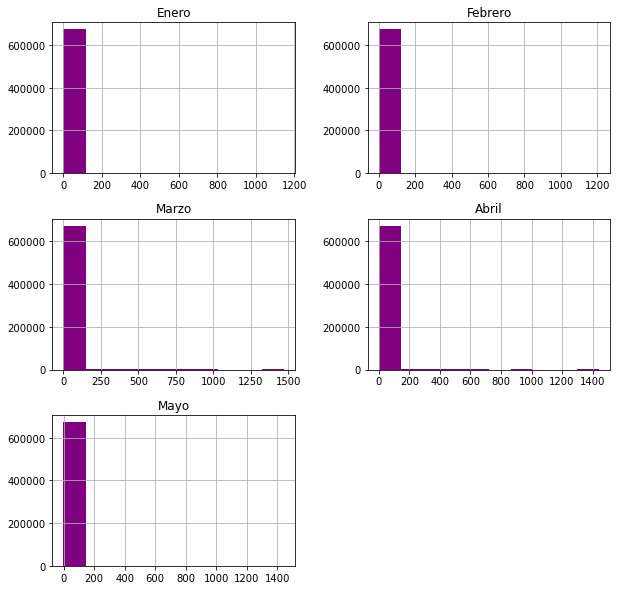

In [31]:
X_1[best_1].hist(figsize=(10,10),color='purple')

In [32]:
for v,li,ls in X_1[best_1].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X_1[f'ex_{v}'] = ((X_1[v]<li)|(X_1[v]>ls)).astype(int)
X_1['ex_'] = X_1.filter(like='ex_').max(axis=1)
X_1['ex_'].value_counts(1)

0    0.98645
1    0.01355
Name: ex_, dtype: float64

In [33]:
for v,li,ls in X_1[best_1].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X_1.loc[X_1[v]<li,v] = np.nan
    X_1.loc[X_1[v]>ls,v] = np.nan

In [34]:
sm = SimpleImputer(strategy='median')
sm.fit(X_1[best_1])

SimpleImputer(strategy='median')

In [35]:
S_1 = pd.DataFrame(sm.transform(X_1[best_1]),columns=best_1)
S_1[um+vart_1] = X_1[um+vart_1].values

In [36]:
ks = pd.DataFrame(map(lambda v: (v,stats.ks_2samp(S_1[v],X_1[v].dropna()).statistic),best_1),
                  columns=['var','ks']).set_index('var').sort_values(by='ks',ascending=False)
ks

,ks
var,
Marzo,0.000649
Febrero,0.000635
Enero,0.000630
Abril,0.000629
Mayo,0.000614


In [37]:
fuera = [v for v in ks.index if ks['ks'][v]>0.05]
fuera

[]

array([[<AxesSubplot:title={'center':'Enero'}>,
        <AxesSubplot:title={'center':'Febrero'}>],
       [<AxesSubplot:title={'center':'Marzo'}>,
        <AxesSubplot:title={'center':'Abril'}>],
       [<AxesSubplot:title={'center':'Mayo'}>, <AxesSubplot:>]],
      dtype=object)

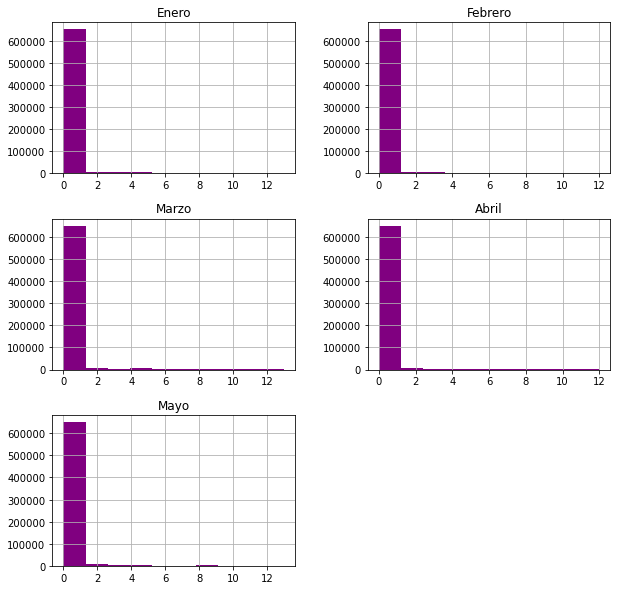

In [38]:
S_1[best_1].hist(figsize=(10,10),color='purple')

### Para vart_2 (Julio)

In [39]:
X_2 = Xi[um+best_2+vart_2].copy()

array([[<AxesSubplot:title={'center':'Enero'}>,
        <AxesSubplot:title={'center':'Febrero'}>],
       [<AxesSubplot:title={'center':'Marzo'}>,
        <AxesSubplot:title={'center':'Abril'}>],
       [<AxesSubplot:title={'center':'Mayo'}>,
        <AxesSubplot:title={'center':'Junio'}>]], dtype=object)

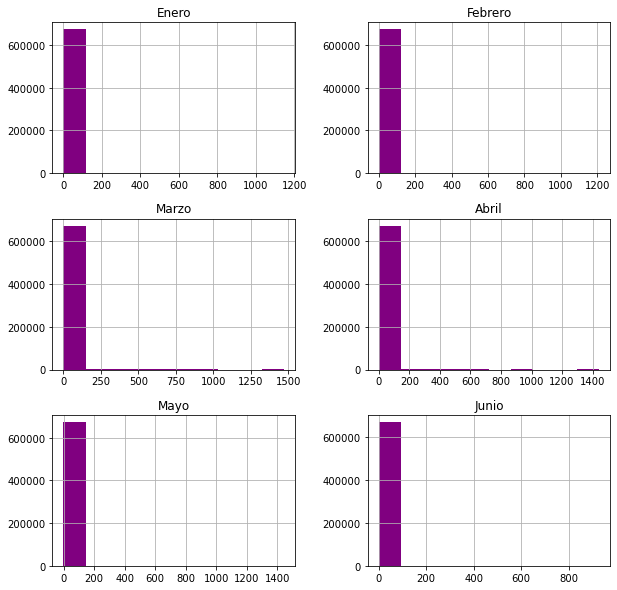

In [40]:
X_2[best_2].hist(figsize=(10,10),color='purple')

In [41]:
for v,li,ls in X_2[best_2].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X_2[f'ex_{v}'] = ((X_2[v]<li)|(X_2[v]>ls)).astype(int)
X_2['ex_'] = X_2.filter(like='ex_').max(axis=1)
X_2['ex_'].value_counts(1)

0    0.98596
1    0.01404
Name: ex_, dtype: float64

In [42]:
for v,li,ls in X_2[best_2].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X_2.loc[X_2[v]<li,v] = np.nan
    X_2.loc[X_2[v]>ls,v] = np.nan

In [43]:
sm.fit(X_2[best_2])

SimpleImputer(strategy='median')

In [44]:
S_2 = pd.DataFrame(sm.transform(X_2[best_2]),columns=best_2)
S_2[um+vart_2] = X_2[um+vart_2].values

In [45]:
ks = pd.DataFrame(map(lambda v: (v,stats.ks_2samp(S_2[v],X_2[v].dropna()).statistic),best_2),
                  columns=['var','ks']).set_index('var').sort_values(by='ks',ascending=False)
ks

,ks
var,
Marzo,0.000649
Febrero,0.000635
Enero,0.000630
Abril,0.000629
Junio,0.000619
Mayo,0.000614


In [46]:
fuera = [v for v in ks.index if ks['ks'][v]>0.05]
fuera

[]

array([[<AxesSubplot:title={'center':'Enero'}>,
        <AxesSubplot:title={'center':'Febrero'}>],
       [<AxesSubplot:title={'center':'Marzo'}>,
        <AxesSubplot:title={'center':'Abril'}>],
       [<AxesSubplot:title={'center':'Mayo'}>,
        <AxesSubplot:title={'center':'Junio'}>]], dtype=object)

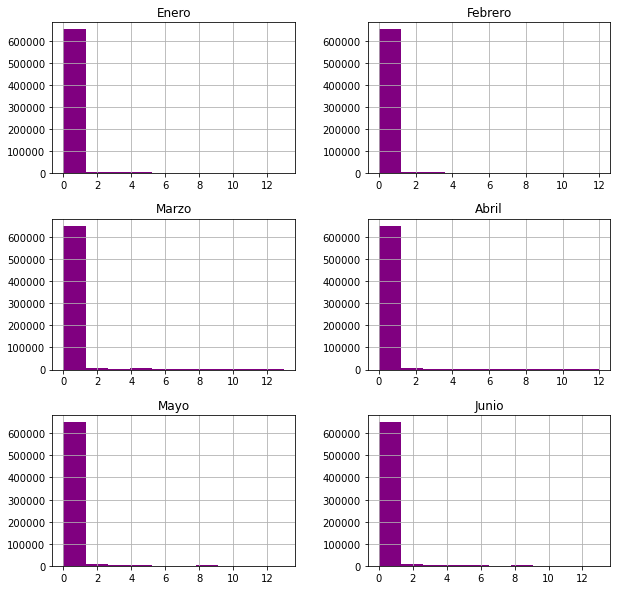

In [47]:
S_2[best_2].hist(figsize=(10,10),color='purple')

### Para vart_3 (Agosto)

In [48]:
X_3 = Xi[um+best_3+vart_3].copy()

array([[<AxesSubplot:title={'center':'Enero'}>,
        <AxesSubplot:title={'center':'Febrero'}>,
        <AxesSubplot:title={'center':'Marzo'}>],
       [<AxesSubplot:title={'center':'Abril'}>,
        <AxesSubplot:title={'center':'Mayo'}>,
        <AxesSubplot:title={'center':'Junio'}>],
       [<AxesSubplot:title={'center':'Julio'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

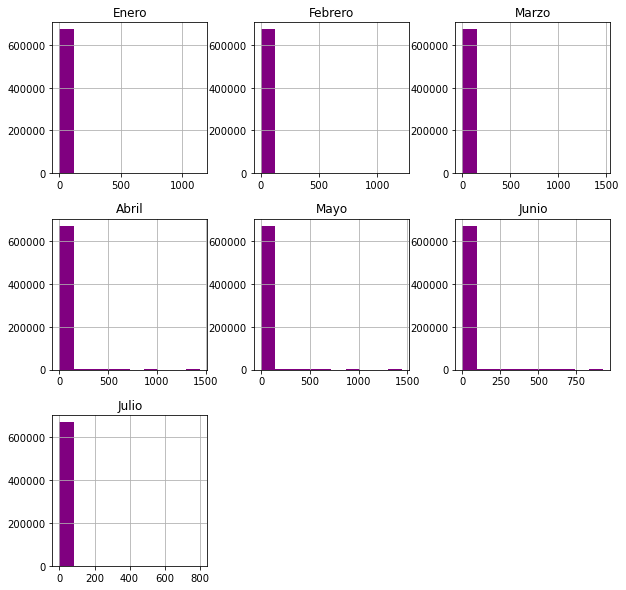

In [49]:
X_3[best_3].hist(figsize=(10,10),color='purple')

In [50]:
for v,li,ls in X_3[best_3].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X_3[f'ex_{v}'] = ((X_3[v]<li)|(X_3[v]>ls)).astype(int)
X_3['ex_'] = X_3.filter(like='ex_').max(axis=1)
X_3['ex_'].value_counts(1)

0    0.985475
1    0.014525
Name: ex_, dtype: float64

In [51]:
for v,li,ls in X_3[best_3].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X_3.loc[X_3[v]<li,v] = np.nan
    X_3.loc[X_3[v]>ls,v] = np.nan

In [52]:
sm.fit(X_3[best_3])

SimpleImputer(strategy='median')

In [53]:
S_3 = pd.DataFrame(sm.transform(X_3[best_3]),columns=best_3)
S_3[um+vart_3] = X_3[um+vart_3].values

In [54]:
ks = pd.DataFrame(map(lambda v: (v,stats.ks_2samp(S_3[v],X_3[v].dropna()).statistic),best_3),
                  columns=['var','ks']).set_index('var').sort_values(by='ks',ascending=False)
ks

,ks
var,
Marzo,0.000649
Febrero,0.000635
Enero,0.000630
Abril,0.000629
Julio,0.000628
Junio,0.000619
Mayo,0.000614


In [55]:
fuera = [v for v in ks.index if ks['ks'][v]>0.05]
fuera

[]

array([[<AxesSubplot:title={'center':'Enero'}>,
        <AxesSubplot:title={'center':'Febrero'}>,
        <AxesSubplot:title={'center':'Marzo'}>],
       [<AxesSubplot:title={'center':'Abril'}>,
        <AxesSubplot:title={'center':'Mayo'}>,
        <AxesSubplot:title={'center':'Junio'}>],
       [<AxesSubplot:title={'center':'Julio'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

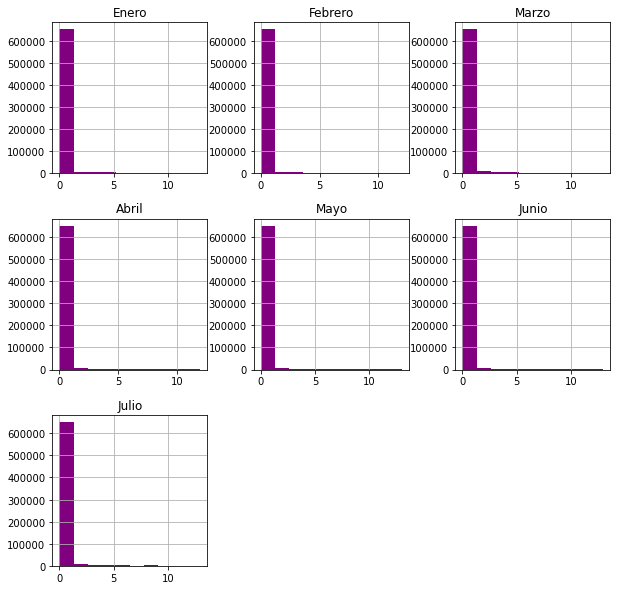

In [56]:
S_3[best_3].hist(figsize=(10,10),color='purple')

# Estandarización de variables

## Para vart_1

In [57]:
sc = StandardScaler()
sc.fit(S_1[best_1])

StandardScaler()

In [58]:
Sc_1 = pd.DataFrame(sc.transform(S_1[best_1]),columns=best_1)
Sc_1[um+vart_1] = S_1[um+vart_1].values

## Para vart_2

In [59]:
sc = StandardScaler()
sc.fit(S_2[best_2])

StandardScaler()

In [60]:
Sc_2 = pd.DataFrame(sc.transform(S_2[best_2]),columns=best_2)
Sc_2[um+vart_2] = S_2[um+vart_2].values

## Para vart_3

In [61]:
sc = StandardScaler()
sc.fit(S_3[best_3])

StandardScaler()

In [62]:
Sc_3 = pd.DataFrame(sc.transform(S_3[best_3]),columns=best_3)
Sc_3[um+vart_3] = S_3[um+vart_3].values

# Partición de entrenamiento

## vart_1

In [63]:
Xt_1,Xv_1 = train_test_split(Sc_1,train_size=0.7)
Xt_1.reset_index(drop=True,inplace=True)
Xv_1.reset_index(drop=True,inplace=True)

## vart_2

In [64]:
Xt_2,Xv_2 = train_test_split(Sc_2,train_size=0.7)
Xt_2.reset_index(drop=True,inplace=True)
Xv_2.reset_index(drop=True,inplace=True)

## vart_3

In [65]:
Xt_3,Xv_3 = train_test_split(Sc_3,train_size=0.7)
Xt_3.reset_index(drop=True,inplace=True)
Xv_3.reset_index(drop=True,inplace=True)

# Aprendizaje

## vart_1

In [88]:
modelo_1 = MLPRegressor()

hp = dict(hidden_layer_sizes=[(a,b,c) for a in range(2,3) for b in range(2,4) for c in range(2,3)],
         activation = ['identity','logistic','tanh','relu'],
         solver=['sgd'],
         alpha = np.arange(0.0001,0.001,0.0001),
         learning_rate=['constant','invscaling','adaptive'],
         max_iter = [100])

grid = RandomizedSearchCV(param_distributions=hp,
                         n_iter=1,
                         cv = 2,
                         n_jobs=-1,
                         verbose=True,
                         estimator = modelo_1)

In [89]:
grid.fit(Xt_1[best_1],Xt_1[vart_1[0]])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/oscarjarillo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/oscarjarillo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/oscarjarillo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



RandomizedSearchCV(cv=2, estimator=MLPRegressor(), n_iter=1, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                                        'hidden_layer_sizes': [(2, 2, 2),
                                                               (2, 3, 2)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [100], 'solver': ['sgd']},
                   verbose=True)

In [90]:
grid.best_params_

{'solver': 'sgd',
 'max_iter': 100,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (2, 2, 2),
 'alpha': 0.0001,
 'activation': 'logistic'}

In [92]:
modelo_1 = grid.best_estimator_
modelo_1

MLPRegressor(activation='logistic', hidden_layer_sizes=(2, 2, 2),
             learning_rate='adaptive', max_iter=100, solver='sgd')

In [93]:
modelo_1.fit(Xt_1[best_1],Xt_1[vart_1[0]])

/home/oscarjarillo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



MLPRegressor(activation='logistic', hidden_layer_sizes=(2, 2, 2),
             learning_rate='adaptive', max_iter=100, solver='sgd')

### Validación del modelo

In [98]:
Xt_1['y^'] = modelo_1.predict(Xt_1[best_1]).astype(int)
Xv_1['y^'] = modelo_1.predict(Xv_1[best_1]).astype(int)

In [99]:
print(mean_absolute_error(y_pred=Xt_1['y^'],y_true=Xt_1[vart_1[0]]))
print(mean_absolute_error(y_pred=Xv_1['y^'],y_true=Xv_1[vart_1[0]]))

0.6063745121384413
0.6150421661987036


In [100]:
print(r2_score(y_pred=Xt_1['y^'],y_true=Xt_1[vart_1[0]]))
print(r2_score(y_pred=Xv_1['y^'],y_true=Xv_1[vart_1[0]]))

0.012056067444931262
0.012703874905100165


In [101]:
print('Mal = ',Xv_1.loc[Xv_1[vart_1[0]]!=Xv_1['y^']].shape[0])
print('Bien = ',Xv_1.loc[Xv_1[vart_1[0]]==Xv_1['y^']].shape[0])

Mal =  15235
Bien =  186704


In [106]:
Xt_1.head(50)

,Enero,Febrero,Marzo,Abril,Mayo,id,Junio,y^
0,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,76078,0,0
1,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,170864,0,0
2,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,21886,0,0
3,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,255349,0,0
4,0.849108,-0.186109,-0.186671,0.920121,1.884164,622946,2,0
5,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,355876,0,0
6,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,562057,0,0
7,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,289577,0,0
8,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,173502,1,0
9,-0.184528,-0.186109,-0.186671,-0.184992,-0.184144,641501,0,0


## vart_2

In [73]:
modelo_2 = LinearRegression(n_jobs=-1)
modelo_2.fit(Xt_2[best_2],Xt_2[vart_2[0]])

LinearRegression(n_jobs=-1)

In [74]:
modelo_2.coef_

array([0.22113209, 0.13470847, 0.16576671, 0.13910395, 0.29150445,
       0.22798319])

In [75]:
modelo_2.intercept_

0.6952295318168477

### Validación del modelo

In [76]:
Xt_2['y^'] = modelo_2.predict(Xt_2[best_2]).astype(int)
Xv_2['y^'] = modelo_2.predict(Xv_2[best_2]).astype(int)

In [77]:
print(mean_absolute_error(y_pred=Xt_2['y^'],y_true=Xt_2[vart_2[0]]))
print(mean_absolute_error(y_pred=Xv_2['y^'],y_true=Xv_2[vart_2[0]]))

0.6325253772902169
0.6131207939031094


In [78]:
print(r2_score(y_pred=Xt_2['y^'],y_true=Xt_2[vart_2[0]]))
print(r2_score(y_pred=Xv_2['y^'],y_true=Xv_2[vart_2[0]]))

0.010575018986694329
0.011805247191404522


In [79]:
print('Mal = ',Xv_2.loc[Xv_2[vart_2[0]]!=Xv_2['y^']].shape[0])
print('Bien = ',Xv_2.loc[Xv_2[vart_2[0]]==Xv_2['y^']].shape[0])

Mal =  17673
Bien =  184266


## vart_3

In [80]:
modelo_3 = LinearRegression(n_jobs=-1)
modelo_3.fit(Xt_3[best_3],Xt_3[vart_3[0]])

LinearRegression(n_jobs=-1)

In [81]:
modelo_3.coef_

array([0.24540026, 0.10498836, 0.18281295, 0.11243772, 0.24081299,
       0.20628506, 0.16142751])

In [82]:
modelo_3.intercept_

0.7047183544722004

### Validación del modelo

In [83]:
Xt_3['y^'] = modelo_3.predict(Xt_3[best_3]).astype(int)
Xv_3['y^'] = modelo_3.predict(Xv_3[best_3]).astype(int)

In [84]:
print(mean_absolute_error(y_pred=Xt_3['y^'],y_true=Xt_3[vart_3[0]]))
print(mean_absolute_error(y_pred=Xv_3['y^'],y_true=Xv_3[vart_3[0]]))

0.6393442970867317
0.642491049277257


In [85]:
print(r2_score(y_pred=Xt_3['y^'],y_true=Xt_3[vart_3[0]]))
print(r2_score(y_pred=Xv_3['y^'],y_true=Xv_3[vart_3[0]]))

0.011803760891901494
0.011979045043722047


In [86]:
print('Mal = ',Xv_3.loc[Xv_3[vart_3[0]]!=Xv_3['y^']].shape[0])
print('Bien = ',Xv_3.loc[Xv_3[vart_3[0]]==Xv_3['y^']].shape[0])

Mal =  17767
Bien =  184172


# Proyecciones

In [87]:
sc = StandardScaler()

In [88]:
Proyecciones = df[df.columns[:-4]].loc[df['Año']==2023]

In [89]:
Proyecciones['Junio'] = modelo_1.predict(pd.DataFrame(sc.fit_transform(Proyecciones[best_1]),columns=best_1)).astype(int)
Proyecciones['Julio'] = modelo_2.predict(pd.DataFrame(sc.fit_transform(Proyecciones[best_2]),columns=best_2)).astype(int)
Proyecciones['Agosto'] = modelo_3.predict(pd.DataFrame(sc.fit_transform(Proyecciones[best_3]),columns=best_3)).astype(int)

In [90]:
Proyecciones.head()

,id,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto
673128,673129,2023,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo a casa habitación,Con violencia,4,5,6,2,3,1,1,1
673129,673130,2023,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo a casa habitación,Sin violencia,143,120,131,144,134,24,25,27
673130,673131,2023,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,4,7,4,4,5,1,1,1
673131,673132,2023,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,32,29,65,56,65,9,10,10
673132,673133,2023,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Con violencia,0,3,4,1,1,0,0,0


In [115]:
Proyecciones.to_csv('Proyecciones_jun_jul_agos.csv',columns=Proyecciones.columns, encoding='latin-1',sep =',',index=False)

# Descuento en el valor del seguro

In [92]:
desc = Proyecciones.copy()

In [93]:
desc['Robos_proyecciones'] = desc[vart_1[0]]+desc[vart_2[0]]+desc[vart_3[0]]

In [94]:
filtro_1 = desc.groupby('Subtipo de delito').agg({'Robos_proyecciones':'sum'}).sort_values(by='Robos_proyecciones',
                                    ascending=True)
filtro_1

,Robos_proyecciones
Subtipo de delito,
Robo a institución bancaria,0
Robo de ganado,30
Robo de maquinaria,39
Robo en transporte público individual,66
Robo a transeúnte en espacio abierto al público,223
Robo a transportista,354
Robo en transporte individual,550
Robo en transporte público colectivo,572
Robo de autopartes,1058


In [95]:
media_robos = np.median(filtro_1['Robos_proyecciones'])
media_robos

561.0

In [96]:
subtipos = [v for v in filtro_1['Robos_proyecciones'].index if filtro_1['Robos_proyecciones'][v]>=media_robos]
subtipos

['Robo en transporte público colectivo',
 'Robo de autopartes',
 'Robo a casa habitación',
 'Robo a transeúnte en vía pública',
 'Robo a negocio',
 'Robo de vehículo automotor',
 'Otros robos']

In [97]:
filtro_2 = pd.concat(map(lambda m: desc.loc[desc['Subtipo de delito']==m],subtipos))
filtro_2

,id,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Robos_proyecciones
673146,673147,2023,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo en transporte público colectivo,Con violencia,0,0,3,1,0,0,0,0,0
673147,673148,2023,1,Aguascalientes,1001,Aguascalientes,El patrimonio,Robo,Robo en transporte público colectivo,Sin violencia,2,0,1,2,2,0,0,0,0
673182,673183,2023,1,Aguascalientes,1002,Asientos,El patrimonio,Robo,Robo en transporte público colectivo,Con violencia,0,0,0,0,0,0,0,0,0
673183,673184,2023,1,Aguascalientes,1002,Asientos,El patrimonio,Robo,Robo en transporte público colectivo,Sin violencia,0,0,0,0,0,0,0,0,0
673218,673219,2023,1,Aguascalientes,1003,Calvillo,El patrimonio,Robo,Robo en transporte público colectivo,Con violencia,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762443,762444,2023,32,Zacatecas,32056,Zacatecas,El patrimonio,Robo,Otros robos,Sin violencia,58,58,51,69,51,10,11,11,32
762478,762479,2023,32,Zacatecas,32057,Trancoso,El patrimonio,Robo,Otros robos,Con violencia,0,1,0,0,5,0,0,0,0
762479,762480,2023,32,Zacatecas,32057,Trancoso,El patrimonio,Robo,Otros robos,Sin violencia,0,3,3,6,4,1,1,1,3
762514,762515,2023,32,Zacatecas,32058,Santa María de la Paz,El patrimonio,Robo,Otros robos,Con violencia,0,0,0,0,0,0,0,0,0


In [98]:
aux = filtro_2.groupby(['Municipio','Modalidad'],as_index=False).agg({'Robos_proyecciones':'sum'}).sort_values(by='Robos_proyecciones',ascending=True)
aux.groupby('Municipio')['Modalidad'].nunique()

Municipio
Abalá              8
Abasolo            8
Abejones           8
Acacoyagua         8
Acajete            8
                  ..
Zumpango           8
Álamo Temapache    8
Álvaro Obregón     8
Ánimas Trujano     8
Ñuu Savi           8
Name: Modalidad, Length: 2334, dtype: int64

In [99]:
filtro_3 = filtro_2.groupby('Municipio').agg({'Robos_proyecciones':'sum'}).sort_values(by='Robos_proyecciones',
                            ascending=True)
filtro_3 = filtro_3.loc[filtro_3['Robos_proyecciones']>0]
filtro_3

,Robos_proyecciones
Municipio,
Chiautempan,3
Chilchota,3
Romita,3
Axapusco,3
Tonanitla,3
...,...
Ecatepec de Morelos,643
Guadalajara,691
Tijuana,705


In [100]:
media = round(np.mean(filtro_3['Robos_proyecciones']),0)
media

47.0

In [101]:
municipios = [v for v in filtro_3['Robos_proyecciones'].index if filtro_3['Robos_proyecciones'][v]>0 and
             filtro_3['Robos_proyecciones'][v]<=media ]
municipios

['Chiautempan',
 'Chilchota',
 'Romita',
 'Axapusco',
 'Tonanitla',
 'Chiautla',
 'Ramos Arizpe',
 'Apaxco',
 'Tlaltizapán de Zapata',
 'Tarimoro',
 'Tantoyuca',
 'Tapachula',
 'Bacalar',
 'San Diego de la Unión',
 'Moctezuma',
 'Reforma',
 'Tarandacuao',
 'Tlaltenango de Sánchez Román',
 'Tolimán',
 'Axtla de Terrazas',
 'Mapimí',
 'Rosales',
 'Arandas',
 'San Antonio la Isla',
 'Miahuatlán de Porfirio Díaz',
 'Teolocholco',
 'Calera',
 'Tezontepec de Aldama',
 'Teziutlán',
 'Calkiní',
 'Poanas',
 'San Agustín Tlaxiaca',
 'Polotitlán',
 'Miguel Alemán',
 'Camerino Z. Mendoza',
 'Cananea',
 'Canatlán',
 'Mexquitic de Carmona',
 'Uriangato',
 'Tequila',
 'Armería',
 'Pueblo Nuevo',
 'Tepecoacuilco de Trujano',
 'Capulhuac',
 'Castaños',
 'San Andrés Tuxtla',
 'Cedral',
 'Malinalco',
 'Caborca',
 'Bácum',
 'Rosario',
 'Chiapa de Corzo',
 'Atotonilco el Alto',
 'Atotonilco de Tula',
 'Quecholac',
 'Charcas',
 'Río Grande',
 'Tlahuapan',
 'Manuel Doblado',
 'Trancoso',
 'San Buenaventura',

In [102]:
filtro_4 = pd.concat(map(lambda m: filtro_2.loc[filtro_2['Municipio']==m],municipios))
filtro_4 = filtro_4.loc[filtro_4['Robos_proyecciones']>0]
filtro_4

,id,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Robos_proyecciones
747075,747076,2023,29,Tlaxcala,29010,Chiautempan,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,3,5,4,6,3,1,1,1,3
702686,702687,2023,16,Michoacán de Ocampo,16025,Chilchota,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,6,6,8,8,9,1,1,1,3
685979,685980,2023,11,Guanajuato,11026,Romita,El patrimonio,Robo,Otros robos,Sin violencia,3,3,6,4,7,1,1,1,3
697862,697863,2023,15,México,15016,Axapusco,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,9,5,7,6,8,1,1,1,3
701786,701787,2023,15,México,15125,Tonanitla,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,9,7,7,5,3,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692521,692522,2023,13,Hidalgo,13077,Tulancingo de Bravo,El patrimonio,Robo,Robo a negocio,Sin violencia,3,7,7,5,4,1,1,1,3
692499,692500,2023,13,Hidalgo,13077,Tulancingo de Bravo,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,24,21,11,4,23,3,3,4,10
692501,692502,2023,13,Hidalgo,13077,Tulancingo de Bravo,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Sin violencia,15,17,6,6,12,2,2,2,6
692530,692531,2023,13,Hidalgo,13077,Tulancingo de Bravo,El patrimonio,Robo,Otros robos,Con violencia,8,15,17,19,9,2,2,2,6


In [103]:
aux = filtro_4.groupby(['Municipio','Modalidad'],as_index=False).agg({'Robos_proyecciones':'sum'}).sort_values(by='Robos_proyecciones',ascending=True)
aux = aux.groupby('Municipio')['Modalidad'].nunique().sort_values(ascending=True)
aux

Municipio
Mocorito                    1
Huimilpan                   1
Santiago                    1
Huitzuco de los Figueroa    1
Santa María del Río         1
                           ..
Lázaro Cárdenas             5
Emiliano Zapata             6
Lagos de Moreno             6
Teoloyucan                  6
Acolman                     6
Name: Modalidad, Length: 421, dtype: int64

In [104]:
municipios = [v for v in aux.index if aux[v]>=3]
municipios

['Amecameca',
 'Heroica Ciudad de Juchitán de Zaragoza',
 'Zempoala',
 'Apaseo el Alto',
 'Villa Guerrero',
 'Tarímbaro',
 'Atlacomulco',
 'Tecamachalco',
 'Tecate',
 'Tecomán',
 'Zapotlán el Grande',
 'Xochitepec',
 'Tenancingo',
 'Champotón',
 'Dolores Hidalgo Cuna de la Independencia Nacional',
 'Tepeaca',
 'Tepeji del Río de Ocampo',
 'Tuxtla Gutiérrez',
 'Coyotepec',
 'Xonacatlán',
 'Cosoleacaque',
 'Cosamaloapan de Carpio',
 'Coronango',
 'Tezoyuca',
 'Tianguistenco',
 'Tierra Blanca',
 'Zacatlán',
 'Yuriria',
 'Altamira',
 'Teotihuacán',
 'Escárcega',
 'Álamo Temapache',
 'Maravatío',
 'La Magdalena Contreras',
 'Salvatierra',
 'Saltillo',
 'Loreto',
 'San Quintín',
 'Jalpa de Méndez',
 'Jacona',
 'Navojoa',
 'Martínez de la Torre',
 'Santa Cruz de Juventino Rosas',
 'San Luis Río Colorado',
 'Río Bravo',
 'San Cristóbal de las Casas',
 'Ixtlahuaca',
 'Macuspana',
 'San Juan de los Lagos',
 'Otumba',
 'Palenque',
 'Pénjamo',
 'Ocoyoacac',
 'San Juan Bautista Tuxtepec',
 'Pesquer

In [105]:
filtro_6 = pd.concat(map(lambda m: filtro_4.loc[filtro_4['Municipio']==m],municipios))
filtro_6

,id,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Robos_proyecciones
697609,697610,2023,15,México,15009,Amecameca,El patrimonio,Robo,Robo a casa habitación,Sin violencia,1,4,2,6,2,1,1,1,3
697620,697621,2023,15,México,15009,Amecameca,El patrimonio,Robo,Robo a transeúnte en vía pública,Con violencia,3,4,3,5,2,1,1,1,3
697632,697633,2023,15,México,15009,Amecameca,El patrimonio,Robo,Robo a negocio,Con violencia,4,5,1,0,4,1,1,1,3
697611,697612,2023,15,México,15009,Amecameca,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,5,7,6,3,2,1,1,1,3
697643,697644,2023,15,México,15009,Amecameca,El patrimonio,Robo,Otros robos,Sin violencia,5,5,7,4,4,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697358,697359,2023,15,México,15002,Acolman,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,9,16,12,15,15,3,3,3,9
697359,697360,2023,15,México,15002,Acolman,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,7,6,2,2,3,1,1,1,3
697360,697361,2023,15,México,15002,Acolman,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Con violencia,3,2,4,2,6,1,1,1,3
697361,697362,2023,15,México,15002,Acolman,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Sin violencia,4,6,9,8,1,1,1,1,3


In [106]:
filtro_7 = filtro_6.groupby('Municipio').agg({'Robos_proyecciones':'sum'})
filtro_7.sort_values(by='Robos_proyecciones',ascending=True)

,Robos_proyecciones
Municipio,
Tarímbaro,9
Santa Cruz de Juventino Rosas,9
Villa Guerrero,9
Cosamaloapan de Carpio,9
Zacatlán,9
...,...
Apodaca,44
Tecate,45
San Andrés Cholula,45


In [107]:
final = filtro_6.groupby(['Municipio']).agg({'Enero':'sum','Febrero':'sum','Marzo':'sum','Abril':'sum','Mayo':'sum'}).sort_values(by=list(filtro_6.columns[10:][:-4]),
                                                                                                        ascending=True)
final.head(3)

,Enero,Febrero,Marzo,Abril,Mayo
Municipio,,,,,
Villa Guerrero,4,12,11,8,8
Coronango,5,14,5,13,9
Tierra Blanca,6,8,14,12,13


In [108]:
seleccionados = list(final.index[:3])
seleccionados

['Villa Guerrero', 'Coronango', 'Tierra Blanca']

In [109]:
Descuentos = pd.concat(map(lambda m: filtro_6.loc[filtro_6['Municipio']==m],seleccionados))
Descuentos.sort_values(by=list(Descuentos.columns[10:][:-4]),ascending=True)

,id,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Robos_proyecciones
701387,701388,2023,15,México,15113,Villa Guerrero,El patrimonio,Robo,Otros robos,Sin violencia,0,2,4,4,4,1,1,1,3
755171,755172,2023,30,Veracruz de Ignacio de la Llave,30174,Tierra Blanca,El patrimonio,Robo,Otros robos,Sin violencia,1,2,4,3,3,1,1,1,3
731486,731487,2023,21,Puebla,21034,Coronango,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,1,3,1,5,4,1,1,1,3
755161,755162,2023,30,Veracruz de Ignacio de la Llave,30174,Tierra Blanca,El patrimonio,Robo,Robo a negocio,Sin violencia,1,3,3,2,3,1,1,1,3
701355,701356,2023,15,México,15113,Villa Guerrero,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,1,3,4,3,2,1,1,1,3
755141,755142,2023,30,Veracruz de Ignacio de la Llave,30174,Tierra Blanca,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Sin violencia,2,1,1,4,6,1,1,1,3
755148,755149,2023,30,Veracruz de Ignacio de la Llave,30174,Tierra Blanca,El patrimonio,Robo,Robo a transeúnte en vía pública,Con violencia,2,2,6,3,1,1,1,1,3
731519,731520,2023,21,Puebla,21034,Coronango,El patrimonio,Robo,Otros robos,Sin violencia,2,5,2,4,2,1,1,1,3
731487,731488,2023,21,Puebla,21034,Coronango,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Sin violencia,2,6,2,4,3,1,1,1,3
701357,701358,2023,15,México,15113,Villa Guerrero,El patrimonio,Robo,Robo de vehículo automotor,Robo de motocicleta Sin violencia,3,7,3,1,2,1,1,1,3


In [111]:
modalidades = ['Sin violencia','Con violencia','Robo de coche de 4 ruedas Con violencia']
modalidades

['Sin violencia', 'Con violencia', 'Robo de coche de 4 ruedas Con violencia']

In [112]:
D = pd.concat(map(lambda m: Descuentos.loc[Descuentos['Modalidad']==m],modalidades))
D

,id,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Robos_proyecciones
701387,701388,2023,15,México,15113,Villa Guerrero,El patrimonio,Robo,Otros robos,Sin violencia,0,2,4,4,4,1,1,1,3
731519,731520,2023,21,Puebla,21034,Coronango,El patrimonio,Robo,Otros robos,Sin violencia,2,5,2,4,2,1,1,1,3
755161,755162,2023,30,Veracruz de Ignacio de la Llave,30174,Tierra Blanca,El patrimonio,Robo,Robo a negocio,Sin violencia,1,3,3,2,3,1,1,1,3
755171,755172,2023,30,Veracruz de Ignacio de la Llave,30174,Tierra Blanca,El patrimonio,Robo,Otros robos,Sin violencia,1,2,4,3,3,1,1,1,3
755148,755149,2023,30,Veracruz de Ignacio de la Llave,30174,Tierra Blanca,El patrimonio,Robo,Robo a transeúnte en vía pública,Con violencia,2,2,6,3,1,1,1,1,3
731486,731487,2023,21,Puebla,21034,Coronango,El patrimonio,Robo,Robo de vehículo automotor,Robo de coche de 4 ruedas Con violencia,1,3,1,5,4,1,1,1,3


In [114]:
D.to_csv('Proyecciones_descuentos.csv',columns=D.columns, encoding='latin-1',sep =',',index=False)